# 2 Player FPSB Auction with symmetric valuation distributions

## Imports

In [1]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

In [3]:
from bnelearn.strategy import NeuralNetStrategy, TruthfulStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import FirstPriceSealedBidAuction, VickreyAuction
from bnelearn.optimizer import ES
from bnelearn.environment import AuctionEnvironment

In [4]:
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [5]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print(device)

cuda


## Settings

The following cell fully defines an experiment

In [28]:
run_dir = 'fpsb'
run_name = 'test tanh 3'
logdir = os.path.join(root_path, 'notebooks', run_dir , run_name)

## Experiment setup
n_players = 2
n_items = 1
# valuation distribution
u_lo =0
u_hi =10

def strat_to_bidder(strategy, batch_size):
    return Bidder.uniform(u_lo, u_hi, strategy, batch_size = batch_size, n_players=1)

#def strat_to_bidder(strategy, batch_size):
#    return Bidder.normal(10.0, 5.0, strategy, batch_size = batch_size, n_players=1)

## Environment settings
#training batch size
batch_size = 2**15
input_length = 1

# strategy model architecture
size_hidden_layer = 10

# optimization params
epoch = 5000
learning_rate = 1e-1
lr_decay = True
lr_decay_every = 1000
lr_decay_factor = 0.6
baseline = True
momentum = 0.5

sigma = .02 #ES noise parameter
n_perturbations = 32

# plot and log training options
plot_epoch = 50
plot_points = min(250, batch_size)
sample_points = torch.from_numpy(np.linspace(u_lo, u_hi, u_hi+1)).float().view(-1, n_items).cuda()

# tensorboard writer settings

## Setting up the Environment

In [29]:
# for evaluation
def optimal_bid(valuation):
    return valuation * (n_players - 1) / n_players

def log_hyperparams(writer, e):
    writer.add_scalar('hyperparams/batch_size', batch_size, e)
    writer.add_scalar('hyperparams/size_hidden_layer', size_hidden_layer, 0)
    writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
    writer.add_scalar('hyperparams/momentum', momentum, e)
    writer.add_scalar('hyperparams/sigma', sigma, e)
    writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)

def plot_bid_function(fig, v,b, writer=None, e=None, plot_points=100):
    
    # subsample points and plot
    v = v.detach().cpu().numpy()[:plot_points]
    b= b.detach().cpu().numpy()[:plot_points]
    
    optimal = optimal_bid(v)
    fig = plt.gcf()
    plt.cla()
    plt.plot(v,b, 'o', v, optimal, 'r-')
    if is_ipython:
        #display.clear_output(wait=True)
        display.display(plt.gcf())
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

In [30]:
model = NeuralNetStrategy(input_length,
                          size_hidden_layer = size_hidden_layer,
                          requires_grad=False
                         ).to(device)

In [31]:
mechanism = FirstPriceSealedBidAuction(cuda = True)
env = AuctionEnvironment(mechanism,
                  agents = [], #dynamically built
                  max_env_size = 1, #
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_bidder_closure = strat_to_bidder
                 )
optimizer = ES(model=model, environment = env,
               lr = learning_rate, momentum=momentum,
               sigma=sigma, n_perturbations=n_perturbations,
               baseline=baseline)

## Training

Epoch 0: 	total share: 0.147497, diff: -2.128653, 	utility: 4.534276


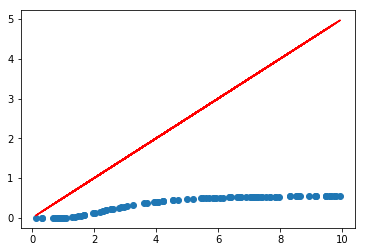

Epoch 50: 	total share: 2.216098, diff: 3.042847, 	utility: -0.530613


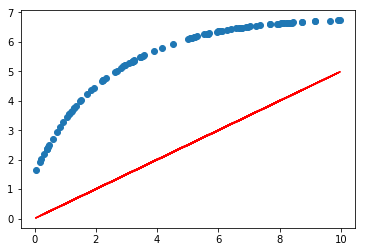

Epoch 100: 	total share: 2.020017, diff: 2.541517, 	utility: -0.051558


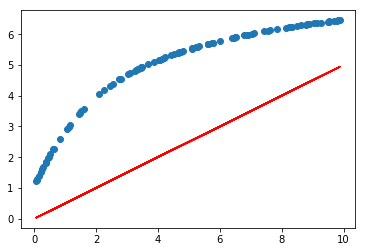

Epoch 150: 	total share: 1.713637, diff: 1.773500, 	utility: 0.716572


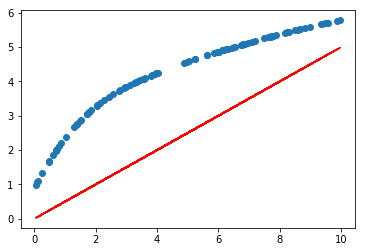

Epoch 200: 	total share: 1.666117, diff: 1.658317, 	utility: 0.845019


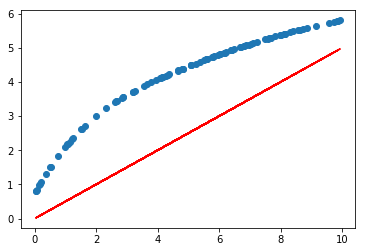

Epoch 250: 	total share: 1.550420, diff: 1.376882, 	utility: 1.118763


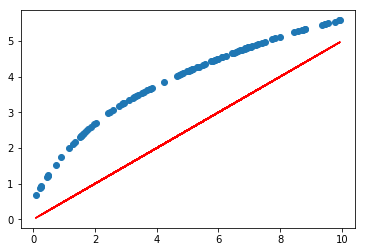

Epoch 300: 	total share: 1.570036, diff: 1.428631, 	utility: 1.062864


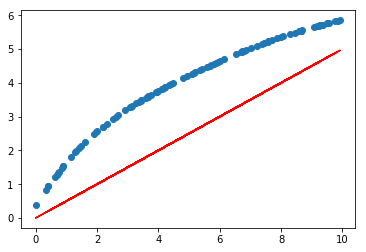

Epoch 350: 	total share: 1.516127, diff: 1.287740, 	utility: 1.205170


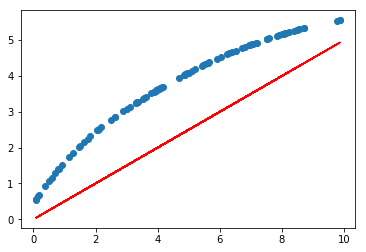

Epoch 400: 	total share: 1.524789, diff: 1.313281, 	utility: 1.197694


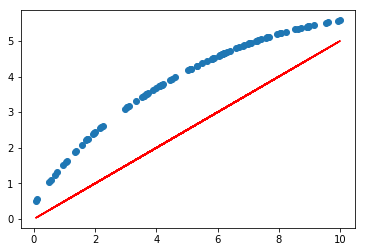

Epoch 450: 	total share: 1.615000, diff: 1.535839, 	utility: 0.964503


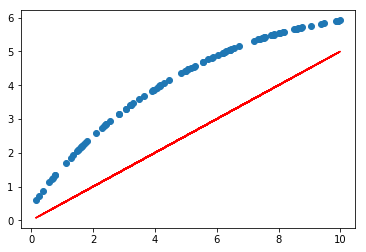

Epoch 500: 	total share: 1.469264, diff: 1.170876, 	utility: 1.321884


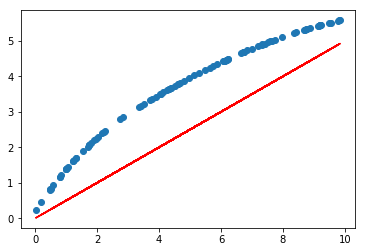

Epoch 550: 	total share: 1.442341, diff: 1.100121, 	utility: 1.395661


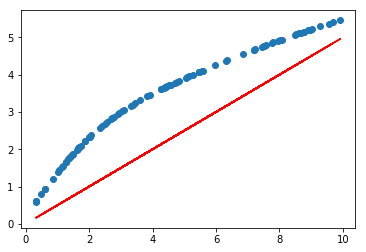

Epoch 600: 	total share: 1.364461, diff: 0.912491, 	utility: 1.565879


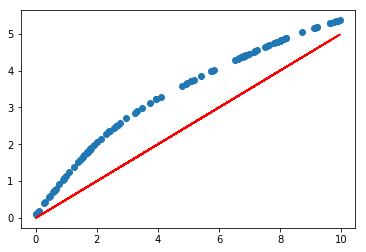

Epoch 650: 	total share: 1.517576, diff: 1.288472, 	utility: 1.204754


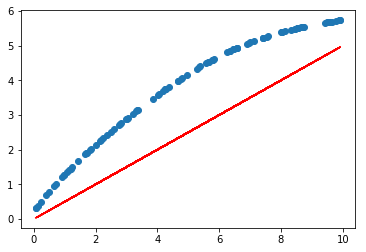

Epoch 700: 	total share: 1.304960, diff: 0.760768, 	utility: 1.722388


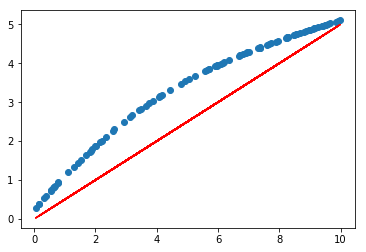

Epoch 750: 	total share: 1.210019, diff: 0.524660, 	utility: 1.969065


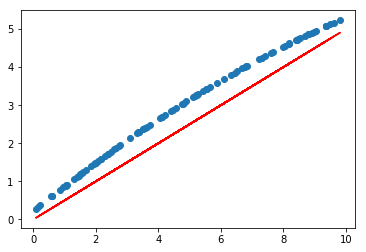

Epoch 800: 	total share: 1.243816, diff: 0.610870, 	utility: 1.885458


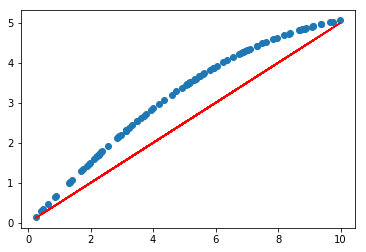

Epoch 850: 	total share: 1.030042, diff: 0.074913, 	utility: 2.399592


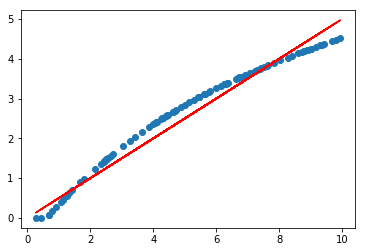

Epoch 900: 	total share: 1.189060, diff: 0.471909, 	utility: 2.033125


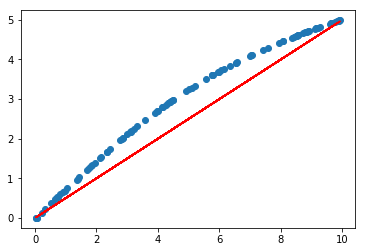

Epoch 950: 	total share: 1.157740, diff: 0.393779, 	utility: 2.095849


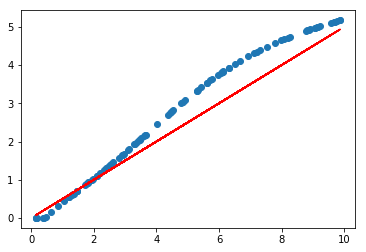

Epoch 1000: 	total share: 1.216899, diff: 0.542012, 	utility: 1.932971


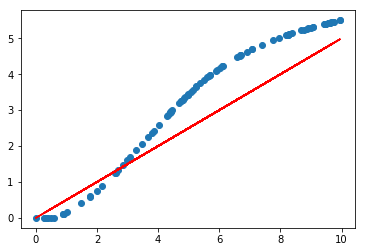

Epoch 1050: 	total share: 1.218314, diff: 0.544328, 	utility: 1.929000


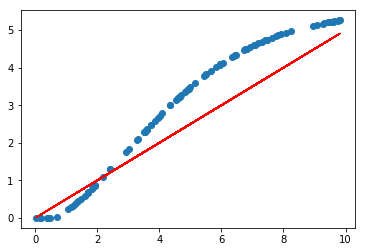

Epoch 1100: 	total share: 1.505563, diff: 1.263888, 	utility: 1.243782


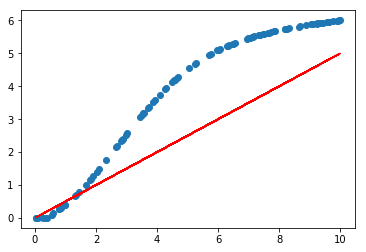

Epoch 1150: 	total share: 1.529545, diff: 1.328878, 	utility: 1.179888


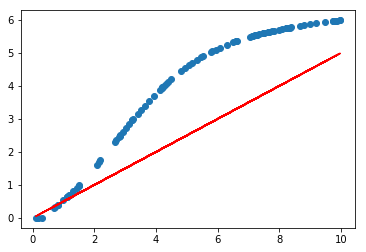

Epoch 1200: 	total share: 1.449311, diff: 1.121482, 	utility: 1.371559


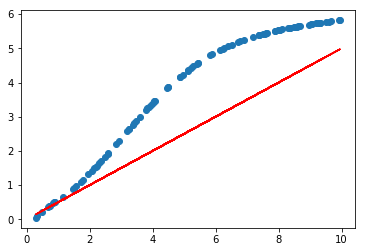

Epoch 1250: 	total share: 1.068246, diff: 0.170399, 	utility: 2.328024


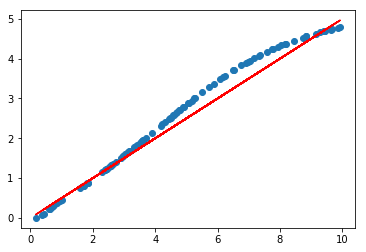

Epoch 1300: 	total share: 0.977235, diff: -0.056645, 	utility: 2.544976


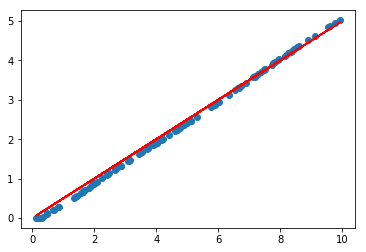

Epoch 1350: 	total share: 0.801929, diff: -0.494515, 	utility: 3.000764


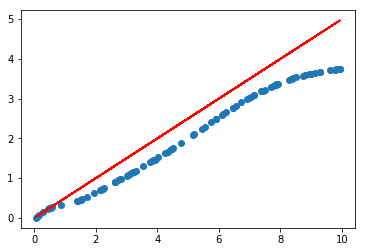

Epoch 1400: 	total share: 1.136045, diff: 0.339862, 	utility: 2.152699


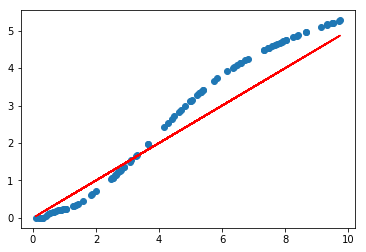

Epoch 1450: 	total share: 1.321918, diff: 0.801665, 	utility: 1.699042


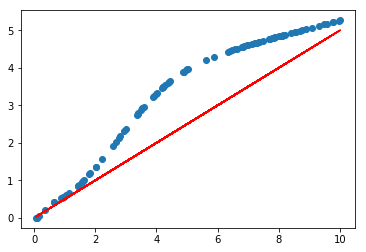

Epoch 1500: 	total share: 1.477457, diff: 1.203593, 	utility: 1.294417


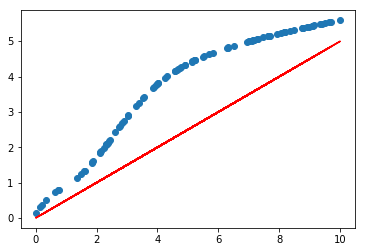

Epoch 1550: 	total share: 1.513883, diff: 1.285337, 	utility: 1.218215


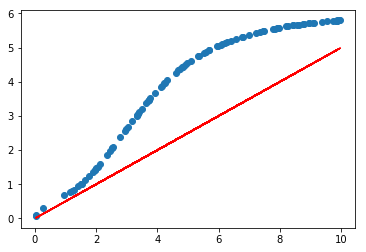

Epoch 1600: 	total share: 1.228297, diff: 0.570872, 	utility: 1.925820


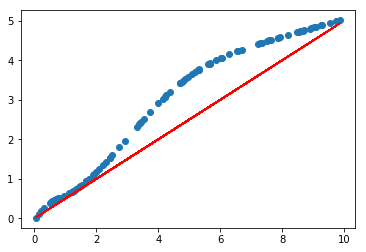

Epoch 1650: 	total share: 1.425887, diff: 1.061033, 	utility: 1.446584


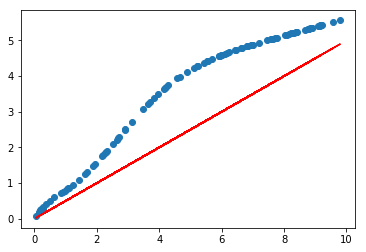

Epoch 1700: 	total share: 1.348451, diff: 0.872062, 	utility: 1.636010


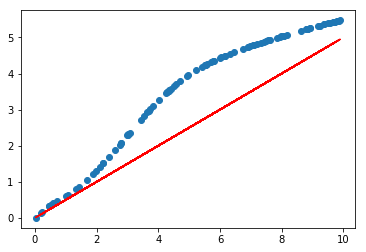

Epoch 1750: 	total share: 0.924493, diff: -0.188427, 	utility: 2.687302


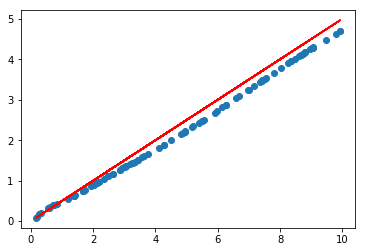

Epoch 1800: 	total share: 1.178062, diff: 0.445509, 	utility: 2.046918


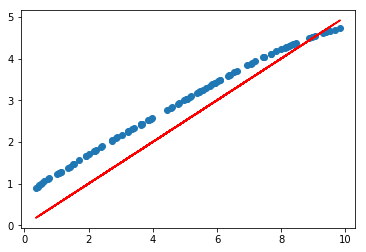

Epoch 1850: 	total share: 1.300795, diff: 0.749318, 	utility: 1.748303


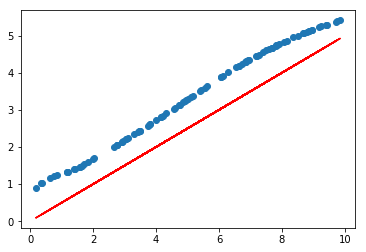

Epoch 1900: 	total share: 1.256928, diff: 0.643539, 	utility: 1.862526


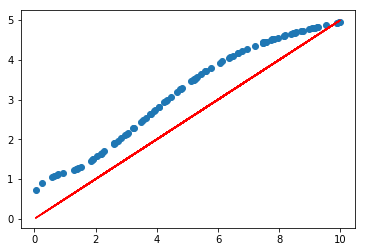

Epoch 1950: 	total share: 1.398696, diff: 1.006845, 	utility: 1.479367


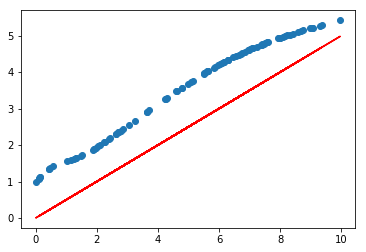

Epoch 2000: 	total share: 1.407246, diff: 1.017003, 	utility: 1.483498


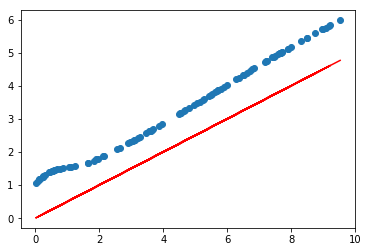

Epoch 2050: 	total share: 1.131815, diff: 0.328948, 	utility: 2.175354


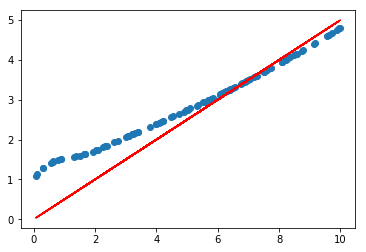

Epoch 2100: 	total share: 1.119629, diff: 0.299790, 	utility: 2.205372


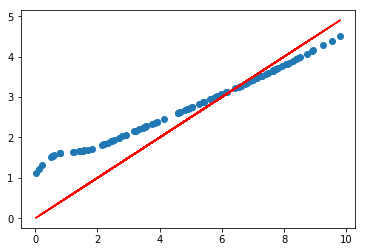

Epoch 2150: 	total share: 1.161089, diff: 0.403435, 	utility: 2.093896


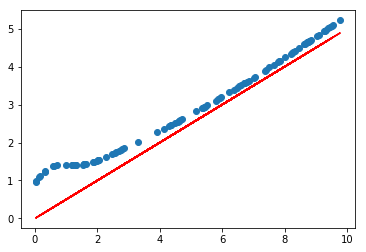

Epoch 2200: 	total share: 1.170075, diff: 0.425914, 	utility: 2.076153


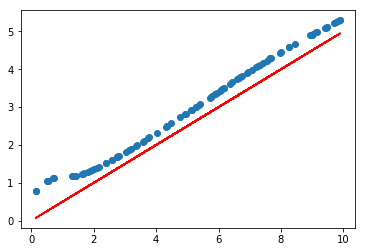

Epoch 2250: 	total share: 0.960321, diff: -0.098719, 	utility: 2.589841


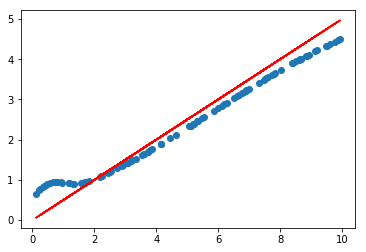

Epoch 2300: 	total share: 1.128263, diff: 0.320405, 	utility: 2.172126


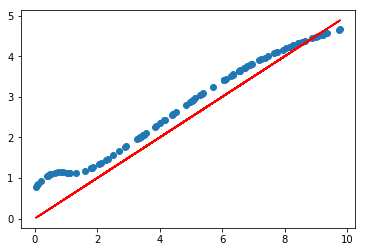

Epoch 2350: 	total share: 1.314673, diff: 0.788332, 	utility: 1.722457


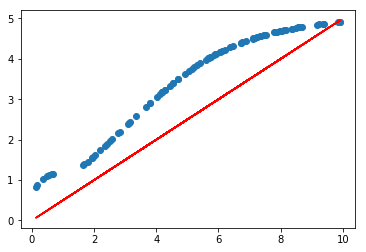

Epoch 2400: 	total share: 1.209321, diff: 0.525188, 	utility: 1.978174


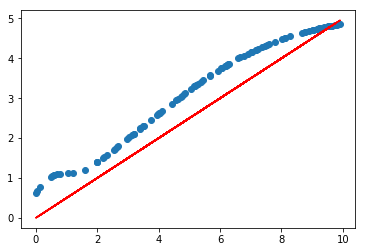

Epoch 2450: 	total share: 1.444308, diff: 1.117070, 	utility: 1.383749


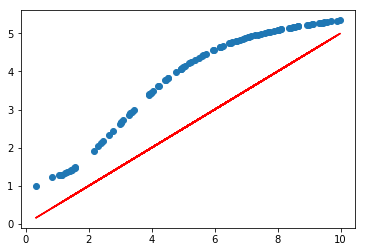

Epoch 2500: 	total share: 1.387897, diff: 0.965120, 	utility: 1.540273


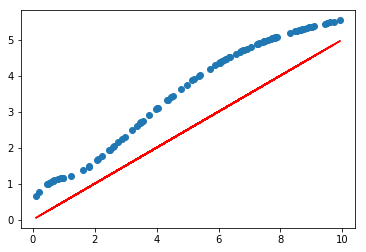

Epoch 2550: 	total share: 1.231964, diff: 0.579068, 	utility: 1.912924


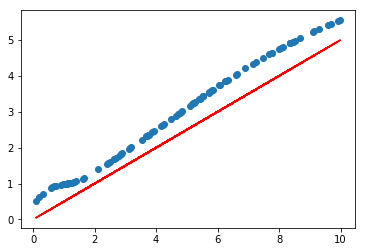

Epoch 2600: 	total share: 1.108702, diff: 0.272466, 	utility: 2.226831


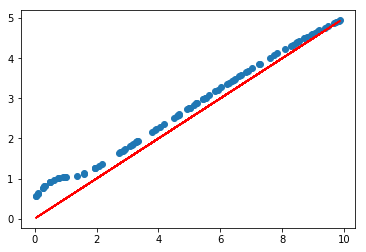

Epoch 2650: 	total share: 1.183443, diff: 0.458938, 	utility: 2.046306


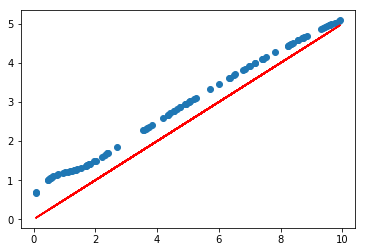

Epoch 2700: 	total share: 1.256302, diff: 0.638117, 	utility: 1.850855


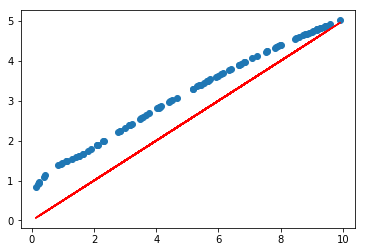

Epoch 2750: 	total share: 1.246262, diff: 0.616384, 	utility: 1.876361


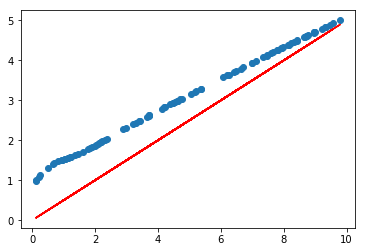

Epoch 2800: 	total share: 1.287107, diff: 0.716051, 	utility: 1.786442


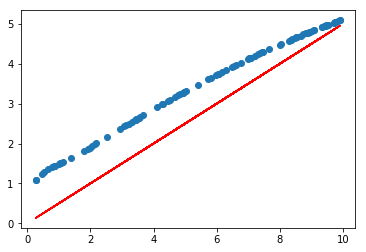

Epoch 2850: 	total share: 1.369985, diff: 0.923788, 	utility: 1.578760


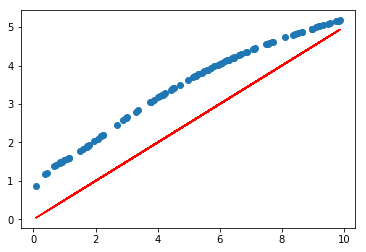

Epoch 2900: 	total share: 1.330749, diff: 0.829979, 	utility: 1.656451


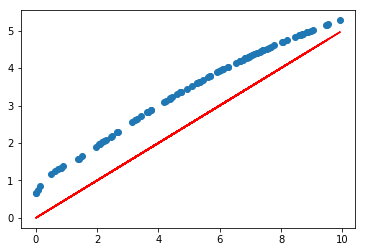

Epoch 2950: 	total share: 1.308320, diff: 0.766012, 	utility: 1.724984


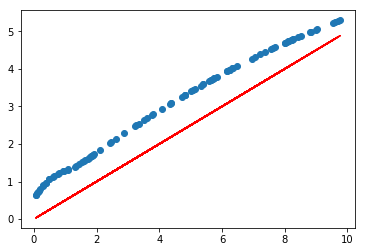

Epoch 3000: 	total share: 1.079965, diff: 0.201518, 	utility: 2.317494


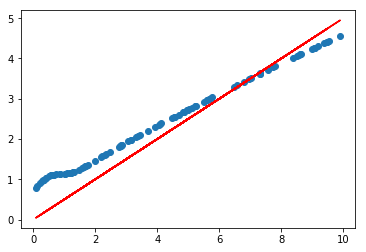

Epoch 3050: 	total share: 1.145484, diff: 0.362752, 	utility: 2.129113


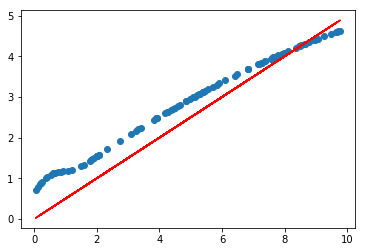

Epoch 3100: 	total share: 1.258632, diff: 0.646850, 	utility: 1.855848


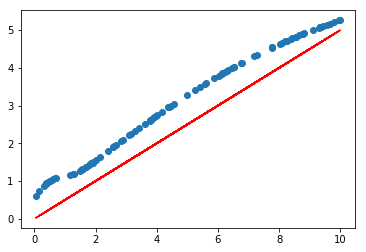

Epoch 3150: 	total share: 1.222018, diff: 0.552469, 	utility: 1.957183


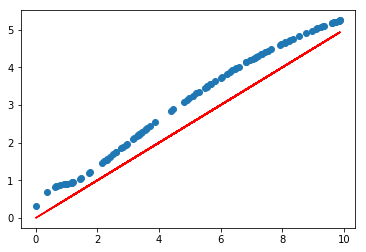

Epoch 3200: 	total share: 1.150208, diff: 0.373533, 	utility: 2.127703


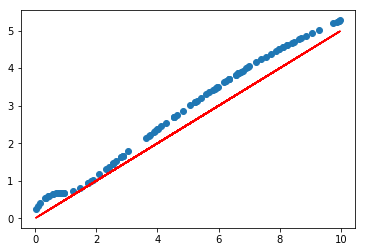

Epoch 3250: 	total share: 1.200652, diff: 0.499179, 	utility: 2.016007


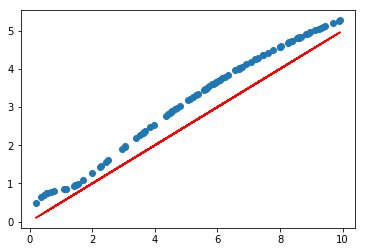

Epoch 3300: 	total share: 1.331730, diff: 0.827169, 	utility: 1.673932


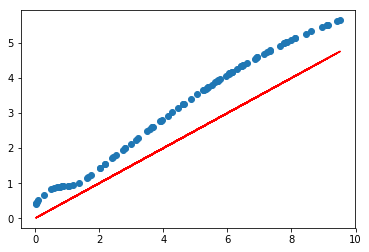

Epoch 3350: 	total share: 1.248612, diff: 0.621019, 	utility: 1.876959


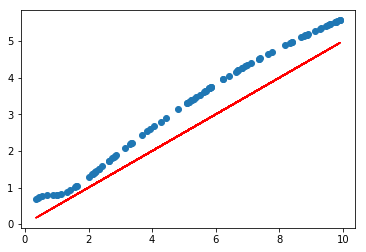

Epoch 3400: 	total share: 1.027973, diff: 0.069657, 	utility: 2.430188


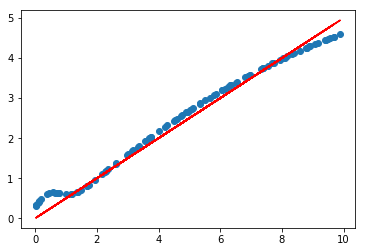

Epoch 3450: 	total share: 1.057034, diff: 0.142309, 	utility: 2.357705


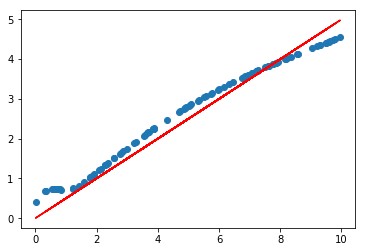

Epoch 3500: 	total share: 1.251739, diff: 0.630134, 	utility: 1.873112


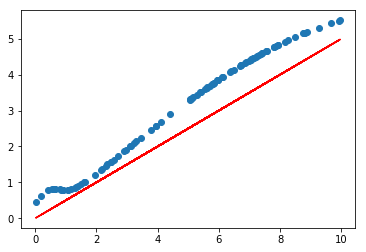

Epoch 3550: 	total share: 1.291161, diff: 0.728190, 	utility: 1.772954


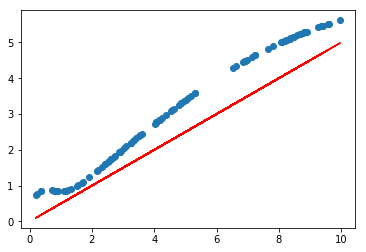

Epoch 3600: 	total share: 1.136186, diff: 0.341480, 	utility: 2.153955


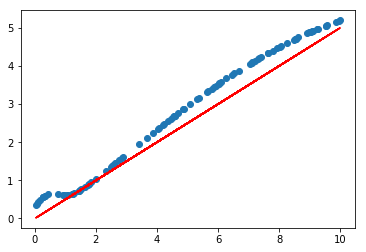

Epoch 3650: 	total share: 1.062445, diff: 0.155878, 	utility: 2.344296


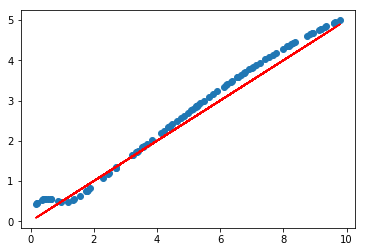

Epoch 3700: 	total share: 0.885399, diff: -0.287542, 	utility: 2.789411


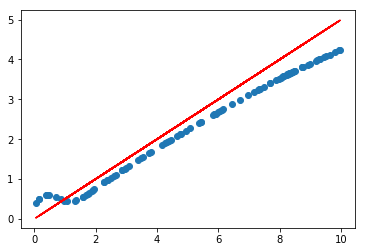

Epoch 3750: 	total share: 0.876321, diff: -0.309514, 	utility: 2.806591


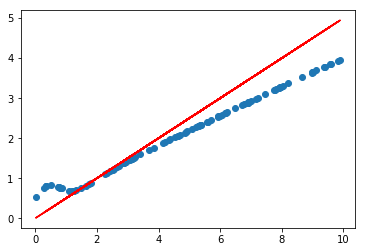

Epoch 3800: 	total share: 1.258314, diff: 0.644639, 	utility: 1.842332


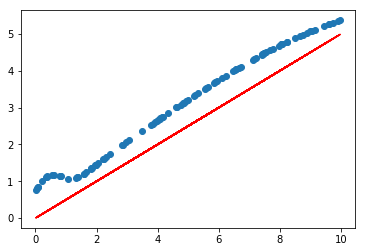

Epoch 3850: 	total share: 1.189585, diff: 0.473729, 	utility: 2.046309


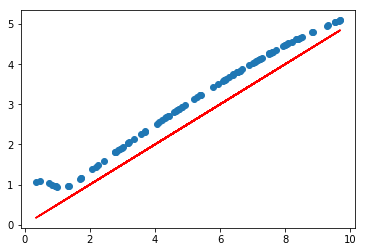

Epoch 3900: 	total share: 1.212958, diff: 0.532261, 	utility: 1.973807


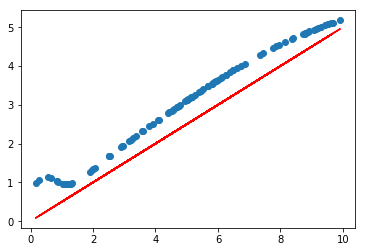

Epoch 3950: 	total share: 1.153958, diff: 0.385494, 	utility: 2.104709


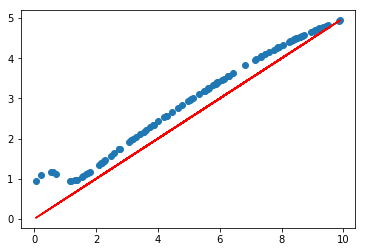

Epoch 4000: 	total share: 1.203510, diff: 0.507863, 	utility: 1.978576


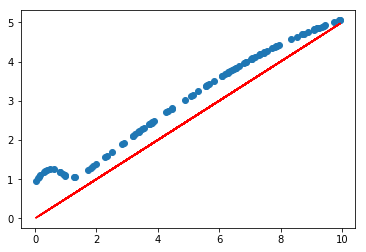

Epoch 4050: 	total share: 1.191783, diff: 0.478269, 	utility: 2.024415


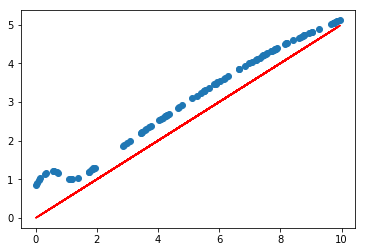

Epoch 4100: 	total share: 1.221956, diff: 0.554302, 	utility: 1.939800


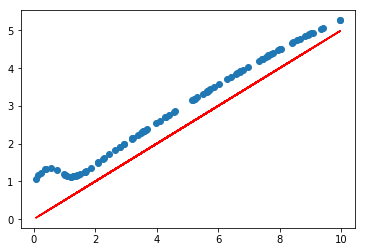

Epoch 4150: 	total share: 1.230182, diff: 0.573346, 	utility: 1.931420


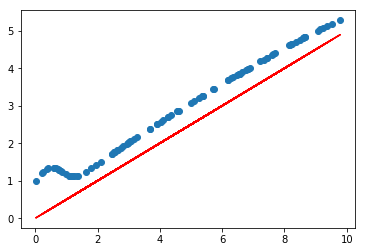

Epoch 4200: 	total share: 1.150853, diff: 0.376146, 	utility: 2.123543


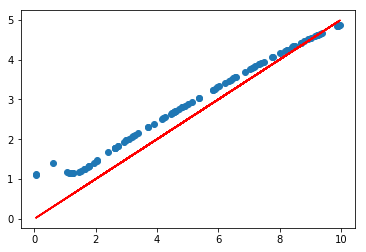

Epoch 4250: 	total share: 1.135104, diff: 0.338657, 	utility: 2.159399


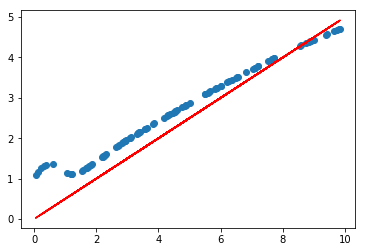

Epoch 4300: 	total share: 1.244645, diff: 0.612570, 	utility: 1.883099


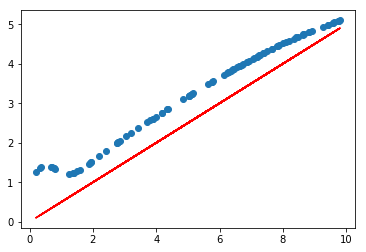

Epoch 4350: 	total share: 1.190750, diff: 0.478631, 	utility: 2.010757


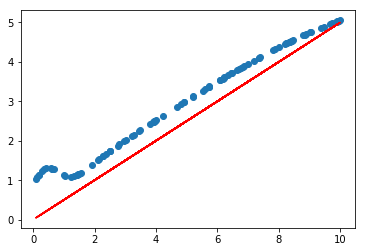

Epoch 4400: 	total share: 1.076534, diff: 0.191837, 	utility: 2.301782


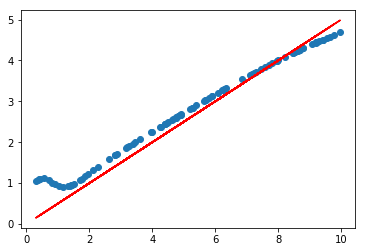

Epoch 4450: 	total share: 1.138859, diff: 0.345094, 	utility: 2.162836


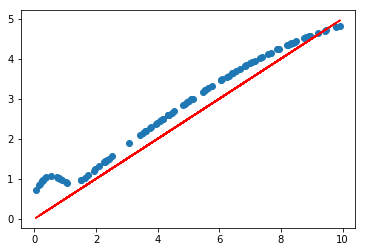

Epoch 4500: 	total share: 1.130885, diff: 0.327733, 	utility: 2.188859


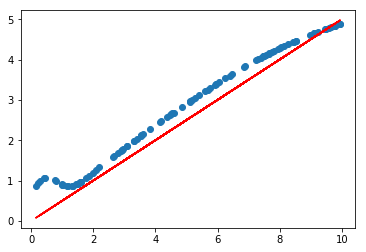

Epoch 4550: 	total share: 1.122334, diff: 0.306212, 	utility: 2.202850


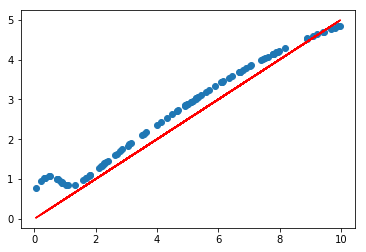

Epoch 4600: 	total share: 1.188887, diff: 0.471591, 	utility: 2.019695


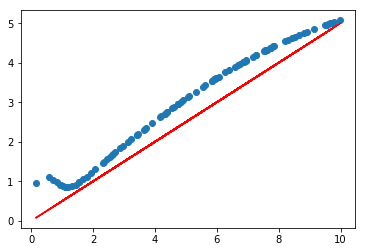

Epoch 4650: 	total share: 1.196587, diff: 0.492729, 	utility: 1.998121


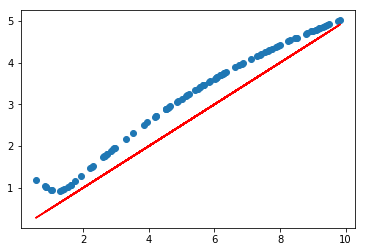

Epoch 4700: 	total share: 1.197540, diff: 0.493250, 	utility: 2.012814


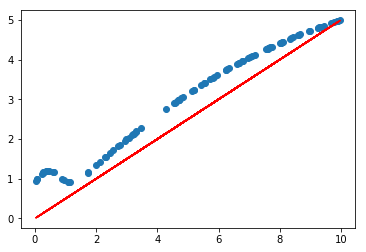

Epoch 4750: 	total share: 1.093927, diff: 0.235505, 	utility: 2.242866


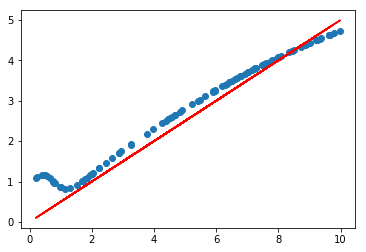

Epoch 4800: 	total share: 1.123062, diff: 0.308823, 	utility: 2.190453


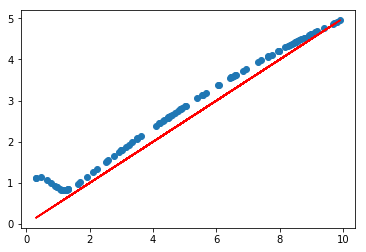

Epoch 4850: 	total share: 1.051980, diff: 0.129987, 	utility: 2.333283


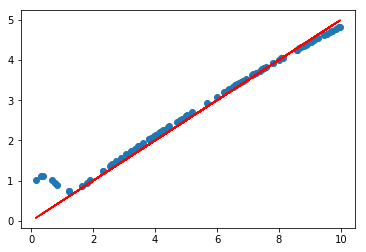

Epoch 4900: 	total share: 1.040035, diff: 0.099917, 	utility: 2.363848


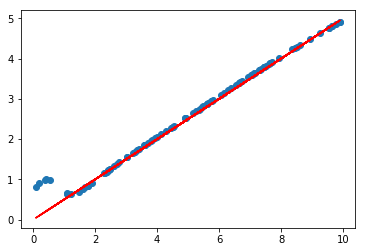

Epoch 4950: 	total share: 1.046704, diff: 0.116620, 	utility: 2.352291


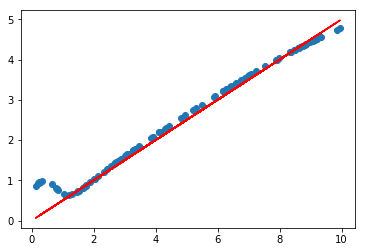

Epoch 5000: 	total share: 1.058317, diff: 0.145208, 	utility: 2.298985


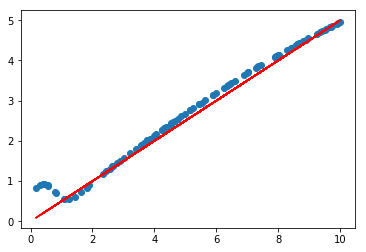

In [32]:
torch.cuda.empty_cache()
writer = SummaryWriter(logdir)
log_hyperparams(writer, 0)
fig = plt.figure()

for e in range(epoch+1):
    # lr decay?
    if lr_decay and e % lr_decay_every == 0 and e > 0:
        learning_rate = learning_rate * lr_decay_factor
        log_hyperparams(writer, e)
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate
        
    # always: do optimizer step
    utility = -optimizer.step()
    writer.add_scalar('eval/utility', utility, e)
    
    if e % plot_epoch == 0:
        # plot current function output
        bidder = strat_to_bidder(model, batch_size)
        bidder.draw_valuations_()
        v = bidder.valuations
        b = bidder.get_action()
        share = b.mean()/optimal_bid(v).mean()
        diff = (b-optimal_bid(v)).mean()
        writer.add_scalar('eval/share', share, e)
        writer.add_scalar('eval/diff', diff, e) 
        
        
        print("Epoch {}: \ttotal share: {:2f}, diff: {:2f}, \tutility: {:2f}".format(e, share, diff, utility))
        plot_bid_function(fig, v,b,writer,e)        

        writer.add_graph(model, bidder.valuations)       
    
   
        
torch.cuda.empty_cache()
writer.close()

In [17]:
writer.close()